In [110]:
# 모듈 불러오기
import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, make_scorer

In [2]:
# 한국어 설정
from matplotlib import font_manager, rc
rc('font', family='Malgun Gothic')

## 1. 데이터 불러오기
### <b> 저는 season 12부터 17까지 컬럼을 엑셀 상에서 미리 삭제했어요 (어차피 하트랜드 안 쓰니까요!!!) <b>

In [61]:
# 데이터 불러오기 1
imdb = pd.read_excel('./imdb_final_6.xlsx', index_col=0)

# 딕셔너리 해제
for i in range(1, 12):
    imdb['season_{}'.format(i)] = imdb.loc[imdb['season_{}'.format(i)].notnull(), 'season_{}'.format(i)].apply(ast.literal_eval)

imdb.tail()

,korean_title,english_title,year,total_season_num,runtime,genre,age_rating,production_country,total_count,total_rate,...,season_9,season_10,season_11,director,writer,actor,imdb_title,imdb_url,wins,nominations
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
900,레일라,Leila,2019,1,46,"드라마, 전쟁, SF",15,인도,9300,5.1,...,NaN,NaN,NaN,"['Deepa Mehta', 'Pawan Kumar', 'Shanker Raman']","['Asad Hussain', 'Deepa Mehta', 'Patrick Graha...","['Huma Qureshi', 'Rahul Khanna', 'Siddharth', ...",Leila (TV Series 2019),https://www.imdb.com/title/tt9337588/,0,0
901,100만 엔의 여인들,Million Yen Women,2017,1,30,"스릴러, 범죄, 드라마, 로맨스",19,일본,2100,7.5,...,NaN,NaN,NaN,"['Hiroto Hara', 'Hirotoshi Hara', 'Kenji Kuwaj...","['Shunjû Aono', 'Yoshimiko Murooka', 'Yoshitak...","['Yôjirô Noda', 'Rila Fukushima', 'Rena Matsui...",1000000 yen no Onnatachi (TV Mini Series 2017),https://www.imdb.com/title/tt6686450/,0,0
902,킬러 코미디언,Hasmukh,2020,1,33,"범죄, 드라마, 스릴러, 코미디",19,인도,2800,5.4,...,NaN,NaN,NaN,['Nikhil Gonsalves'],"['Amogh Ranadive', 'Neeraj Pandey', 'Nikhil Go...","['Vir Das', 'Ranvir Shorey', 'Amrita Bagchi', ...",Hasmukh (TV Mini Series 2020),https://www.imdb.com/title/tt9359294/,2,1
903,달러,Dollar,2019,1,41,"액션, 드라마, 로맨스",15,레바논,651,6.6,...,NaN,NaN,NaN,['Samer Al Barkawi'],['Hisham Hilal'],"['Mark Lewis', 'Adel Karam', 'Amel Bouchoucha'...",Dollar (TV Series 2019),https://www.imdb.com/title/tt10687564/,0,0
904,"엘리트들, 못다 한 이야기: 나디아 구스만",Elite Short Stories: Nadia Guzmán,2021,1,11,"드라마, 로맨스",15,스페인,2100,6.2,...,NaN,NaN,NaN,['Dani de la Orden'],['Carlos Montero'],"['Miguel Bernardeau', 'Mina El Hammani', 'Omar...",Elite Short Stories: Nadia Guzmán (TV Mini Ser...,https://www.imdb.com/title/tt14671790/,0,0


In [28]:
# 데이터 불러오기 2
watcha = pd.read_excel('./watcha_최종본.xlsx', index_col=0)

# 리스트 해제
for i in range(1, 12):
    watcha['season_{}'.format(i)] = watcha.loc[watcha['season_{}'.format(i)].notnull(), 'season_{}'.format(i)].apply(ast.literal_eval)

watcha.tail()

,korean_title,english_title,year,total_season_num,production_country,watcha_name,season_1,season_2,season_3,season_4,season_5,season_6,season_7,season_8,season_9,season_10,season_11
900,레일라,Leila,2019,1,인도,['레일라'],"[3.2, 27, 3]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
901,100만 엔의 여인들,Million Yen Women,2017,1,일본,['100만 엔의 여자들'],"[3.0, 718, 100]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
902,킬러 코미디언,Hasmukh,2020,1,인도,['킬러 코미디언'],"[1.6, 4, 0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903,달러,Dollar,2019,1,레바논,['달러'],"[0.7, 3, 1]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
904,"엘리트들, 못다 한 이야기: 나디아 구스만",Elite Short Stories: Nadia Guzmán,2021,1,스페인,"['엘리트들, 못다 한 이야기: 나디아 구스만']","[2.8, 420, 30]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. 함수 만들기

### (1) IMDb 평점, 평점 매긴 사람 수

In [6]:
# IMDb 평점
def get_imdb_rate(x):
    imdb_rate_lst = []

    # 딕셔너리에서 평점 부분만 가져옴
    for idx, val in x.items():
        imdb_rate_lst.append(val[0])

    # 시즌 평점 평균 구하기
    imdb_rate = np.mean(imdb_rate_lst)

    return imdb_rate

In [7]:
# IMDb 평점 매긴 사람 수
def get_imdb_rate_cnt(x):
    imdb_rate_cnt_lst = []

    # 딕셔너리에서 평점 매긴 사람만 가져옴
    for idx, val in x.items():
        imdb_rate_cnt_lst.append(val[1])


    # 평점을 매긴 사람의 시즌 평균 구하기
    imdb_rate_cnt = np.mean(imdb_rate_cnt_lst)

    return imdb_rate_cnt

### (2) 왓챠 평점, 평점을 매긴 사람 수, 리뷰를 쓴 사람 수

In [8]:
# 왓챠 평점
def get_watcha_rate(x):
    watcha_tmp = x
    watcha_rate = watcha_tmp[0]
    return watcha_rate

In [9]:
# 왓챠 평점을 매긴 사람 수
def get_watcha_rate_cnt(x):
    watcha_tmp = x
    watcha_rate_cnt = watcha_tmp[1]
    return watcha_rate_cnt

In [11]:
# 왓챠 리뷰를 쓴 사람 수
def get_watcha_rev_cnt(x):
    watcha_tmp = x
    watcha_rev_cnt = watcha_tmp[2]
    return watcha_rev_cnt

### (3) 유지도

In [12]:
# 평점 유지도
def get_rate_retention(x):
    imdb_tmp = list(x.values())
    k = len(imdb_tmp)
    score = (imdb_tmp[k-1][0] / imdb_tmp[0][0])
    return score

In [13]:
# 평점 매긴 사람 수의 유지도
def get_rate_cnt_retention(x):
    imdb_tmp = list(x.values())
    k = len(imdb_tmp)
    score = (imdb_tmp[k-1][1] / imdb_tmp[0][1])
    return score

### (4) 제작 국가

In [15]:
# 제작 국가 순위 별 점수 부여
country_scores = {
    "미국": 0.369,
    "대한민국": 0.203,
    "영국": 0.078,
    "스페인": 0.047,
    "멕시코": 0.030,
    "콜롬비아": 0.028,
    "캐나다": 0.024,
    "호주": 0.021,
    "중국": 0.020,
    "프랑스": 0.017,
    "일본": 0.016,
    "브라질": 0.016,
    "독일": 0.015,
    "인도": 0.014,
    "터키": 0.014,
    "이탈리아": 0.013,
    "폴란드": 0.011,
}
# "그 외" 비율
default_score = 0.005
def get_country_score(production_country):
    return country_scores.get(production_country, default_score)

In [16]:
# 제작 국가 점수
imdb['production_country'].apply(get_country_score)

Unnamed: 0
0      0.203
1      0.005
2      0.005
3      0.369
4      0.203
       ...  
900    0.014
901    0.016
902    0.014
903    0.005
904    0.047
Name: production_country, Length: 905, dtype: float64

### (5) 대륙

### (6) 장르

In [17]:
# 넷플릭스 장르 선호도 순위 리스트 (선호도 순서대로 정렬)
genres = [
    '드라마', '코미디', 'SF', '액션', '스릴러', '범죄', '공포', '로맨스', '판타지', '전쟁', '서부', '그 외'
]

# 각 장르에 점수를 선형적으로 할당하여 딕셔너리로 만들기
genre_scores = {genre: 1 - i / (len(genres)) for i, genre in enumerate(genres)}

# '그 외'에 해당되는 장르 리스트
other_genres = ['역사', '가족', '음악', 'Made in Europe', '스포츠']

# 장르 문자열을 받아서 점수를 계산하는 함수

def get_genre_score(genre_str):
    # 장르를 ', '로 분리
    genre_list = genre_str.split(', ')
    
    # '그 외'에 포함된 하위 장르가 있는지 확인
    for genre in genre_list:
        if genre in other_genres:
            return genre_scores['그 외']
    
    # 각 장르의 점수의 평균 계산
    total_score = 0
    count = 0
    for genre in genre_list:
        score = genre_scores.get(genre, genre_scores['그 외'])  # 없는 장르는 '그 외' 점수로 처리
        total_score += score
        count += 1
    
    # 평균 점수 계산
    average_score = total_score / count if count > 0 else 0
    return average_score

### (7) 장르 다양성 지수

In [18]:
# 장르 다양성 지수
def get_genre_diversity(x):
    genre_len = len(x.split(', '))
    return genre_len

### (8) 연령 등급

In [19]:
# 연령 등급에 따른 함수
def get_age_rating_score(x):
    if x == 19:
        return 0.5
    elif x == 15:
        return 0.4
    else:
        return 0.1

## 3. 점수 부여

In [62]:
# 시즌 2가 없는 드라마 모두 삭제!!!
imdb = imdb[imdb['season_2'].notna()]

In [122]:
# 시즌1 점수 부여: 모든 요소에 로그를 취함
for i, row in imdb.iterrows():
    total = 0
    imdb_tmp = imdb.loc[i, 'season_1']; watcha_tmp = watcha.loc[i, 'season_1']
    genre = imdb.loc[i, 'genre']; country = imdb.loc[i, 'production_country']; age = imdb.loc[i, 'age_rating']

    rate = 0.8 * (get_imdb_rate(imdb_tmp)) + 0.2 * (get_watcha_rate(watcha_tmp))
    cnt = 0.8 * np.log(get_imdb_rate_cnt(imdb_tmp)) + 0.2 * np.log(get_watcha_rate_cnt(watcha_tmp))
    ret = 1/4 * (get_rate_retention(imdb_tmp)) + 3/4 * (get_rate_cnt_retention(imdb_tmp))
    info = 0.4 * get_country_score(country) + 0.4 * get_genre_score(genre) + 0.1 * get_genre_diversity(genre) + 0.1 * (get_age_rating_score(age))
    total = (0.7 * (1 * rate + 3 * cnt + 1 * ret) + 0.3 * info)

    imdb.loc[i, 's1_score'] = total

---

In [63]:
# 시즌2 점수 부여
for idx, row in imdb.iterrows():
    imdb_tmp = imdb.loc[idx, 'season_2']; watcha_tmp = watcha.loc[idx, 'season_2']
    genre = imdb.loc[idx, 'genre']; country = imdb.loc[idx, 'production_country']; age = imdb.loc[idx, 'age_rating']

    rate = 0.8 * (get_imdb_rate(imdb_tmp)) + 0.2 * (get_watcha_rate(watcha_tmp))
    cnt = 0.8 * get_imdb_rate_cnt(imdb_tmp) + 0.2 * get_watcha_rate_cnt(watcha_tmp)
    ret = 1/4 * (get_rate_retention(imdb_tmp)) + 3/4 * (get_rate_cnt_retention(imdb_tmp))
    info = 0.4 * get_country_score(country) + 0.4 * get_genre_score(genre) + 0.1 * get_genre_diversity(genre) + 0.1 * (get_age_rating_score(age))
    total = (0.7 * (1 * rate + 3 * cnt + 1 * ret) + 0.3 * info)

    imdb.loc[idx, 's2_score_normal'] = total

In [64]:
# 시즌2 점수 부여: 사람 수에만 로그
for idx, row in imdb.iterrows():
    imdb_tmp = imdb.loc[idx, 'season_2']; watcha_tmp = watcha.loc[idx, 'season_2']
    genre = imdb.loc[idx, 'genre']; country = imdb.loc[idx, 'production_country']; age = imdb.loc[idx, 'age_rating']

    rate = 0.8 * (get_imdb_rate(imdb_tmp)) + 0.2 * (get_watcha_rate(watcha_tmp))
    cnt = 0.8 * np.log(get_imdb_rate_cnt(imdb_tmp)) + 0.2 * np.log(get_watcha_rate_cnt(watcha_tmp))
    ret = 1/4 * (get_rate_retention(imdb_tmp)) + 3/4 * (get_rate_cnt_retention(imdb_tmp))
    info = 0.4 * get_country_score(country) + 0.4 * get_genre_score(genre) + 0.1 * get_genre_diversity(genre) + 0.1 * (get_age_rating_score(age))
    total = (0.7 * (1 * rate + 3 * cnt + 1 * ret) + 0.3 * info)

    imdb.loc[idx, 's2_score_people_log'] = total

In [65]:
# 모두 로그
for idx, row in imdb.iterrows():
    imdb_tmp = imdb.loc[idx, 'season_2']; watcha_tmp = watcha.loc[idx, 'season_2']
    genre = imdb.loc[idx, 'genre']; country = imdb.loc[idx, 'production_country']; age = imdb.loc[idx, 'age_rating']

    rate = 0.8 * np.log(get_imdb_rate(imdb_tmp)) + 0.2 * np.log(get_watcha_rate(watcha_tmp))
    cnt = 0.8 * np.log(get_imdb_rate_cnt(imdb_tmp)) + 0.2 * np.log(get_watcha_rate_cnt(watcha_tmp))
    ret = 1/4 * np.log(get_rate_retention(imdb_tmp)) + 3/4 * np.log(get_rate_cnt_retention(imdb_tmp))
    info = 0.4 * np.log(get_country_score(country)) + 0.4 * np.log(get_genre_score(genre)) + 0.1 * np.log(get_genre_diversity(genre)) + 0.1 * np.log(get_age_rating_score(age))
    total = (0.7 * (1 * rate + 3 * cnt + 1 * ret) + 0.3 * info)

    imdb.loc[idx, 's2_score_all_log'] = total

In [66]:
for idx, row in imdb.iterrows():
    imdb_tmp = imdb.loc[idx, 'season_2']; watcha_tmp = watcha.loc[idx, 'season_2']
    genre = imdb.loc[idx, 'genre']; country = imdb.loc[idx, 'production_country']; age = imdb.loc[idx, 'age_rating']

    rate = 0.8 * np.log1p(get_imdb_rate(imdb_tmp)) + 0.2 * np.log1p(get_watcha_rate(watcha_tmp))
    cnt = 0.8 * np.log1p(get_imdb_rate_cnt(imdb_tmp)) + 0.2 * np.log1p(get_watcha_rate_cnt(watcha_tmp))
    ret = 1/4 * np.log1p(get_rate_retention(imdb_tmp)) + 3/4 * np.log1p(get_rate_cnt_retention(imdb_tmp))
    info = 0.4 * np.log1p(get_country_score(country)) + 0.4 * np.log1p(get_genre_score(genre)) + 0.1 * np.log1p(get_genre_diversity(genre)) + 0.1 * np.log1p(get_age_rating_score(age))
    total = (0.7 * (rate + 3 * cnt + 1 * ret) + 0.3 * info)

    imdb.loc[idx, 's2_score_all_log1p'] = total

## 4. ML

### (1) 전처리

In [67]:
imdb['production_country'] = imdb['production_country'].apply(get_country_score)
imdb['genre_diversity'] = imdb['genre'].apply(get_genre_diversity)
imdb['genre'] = imdb['genre'].apply(get_genre_score)
imdb['age_rating'] = imdb['age_rating'].apply(get_age_rating_score)

In [68]:
imdb['season_1_rate'] = imdb['season_1'].apply(get_imdb_rate)
imdb['season_1_rate_cnt'] = imdb['season_1'].apply(get_imdb_rate_cnt)
imdb['season_1_rate_retention'] = imdb['season_1'].apply(get_rate_retention)
imdb['season_1_rate_cnt_retention'] = imdb['season_1'].apply(get_rate_cnt_retention)

In [69]:
imdb['w_season_1_rate'] = watcha['season_1'].apply(get_watcha_rate)
imdb['w_season_1_rate_cnt'] = watcha['season_1'].apply(get_watcha_rate_cnt)

In [104]:
# 모델 리스트 만들기
models = []
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('AdaBoostClassifier', AdaBoostClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))
models.append(('LogisticRegression', LinearRegression()))

In [125]:
# 모델 목록
models = {
    'DecisionTree': DecisionTreeRegressor(),
    'LinearRegression': LinearRegression(),
    'AdaBoost': AdaBoostRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'LightGBM': LGBMRegressor()
}

# 하이퍼파라미터 그리드 (예시)
param_grids = {
    'DecisionTree': {'max_depth': [3, 5, 10, 20, None]},
    'LinearRegression': {},
    'AdaBoost': {'n_estimators': [50, 100, 200]},
    'GradientBoosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 10, 20, None]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'LightGBM': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
}

# 평가 지표를 위한 함수
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# 맞춤 평가 지표 추가
scoring = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSLE': make_scorer(mean_squared_log_error, greater_is_better=False),
    'RMSLE': make_scorer(rmsle, greater_is_better=False)
}

In [198]:
# 모델 평가 및 하이퍼파라미터 튜닝

def grid_search(X_train, X_test, y_train, y_test, y_name):

    best_models = {}; best_scores={}
    for name, model in models.items():
        print(f"Training {name}...")
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        best_models[name] = grid_search.best_estimator_
        best_scores[name] = grid_search.best_score_
        print(f"Best parameters for {name}: {grid_search.best_params_}")

    # 가장 성능이 좋은 모델 선택
    best_model_name = max(best_scores, key=best_scores.get)
    best_model = best_models[best_model_name]
    print(f"Best model: {best_model_name}")
    
    # 전체 데이터에 대한 예측
    y_pred_best = best_model.predict(X)
    
    # 예측 결과와 실제 결과를 비교
    comparison_df = pd.DataFrame({
        'korean_title': imdb['korean_title'],
        'actual': y_name,
        'predicted': y_pred_best,
        'diff': y_name - y_pred_best
    })
    
    # 가장 성능이 좋은 모델의 피처 중요도 계산 및 시각화
    feature_importances = best_model.feature_importances_
    sorted_idx = np.argsort(feature_importances)

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [X_train.columns[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title(f'{best_model_name} Feature Importances')
    plt.show()

    # 피처 중요도 데이터프레임 생성
    feature_importance_df = pd.DataFrame({
        'Feature': [X_train.columns[i] for i in sorted_idx],
        'Importance': feature_importances[sorted_idx]
    })

    # 각 모델에 대한 평가 지표 계산
    results_list = []
    
    for name, model in best_models.items():
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        msle = mean_squared_log_error(y_test, y_pred)
        rmsle_val = rmsle(y_test, y_pred)
        
        results_list.append({
            'Model': name,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MSLE': msle,
            'RMSLE': rmsle_val
        })
    
    results = pd.DataFrame(results_list)
        
    return feature_importance_df, comparison_df, results

## (3) 인원 수

#### (3)-1 X값에는 로그 안 취함

Training DecisionTree...
Best parameters for DecisionTree: {'max_depth': None}
Training LinearRegression...
Best parameters for LinearRegression: {}
Training AdaBoost...
Best parameters for AdaBoost: {'n_estimators': 100}
Training GradientBoosting...
Best parameters for GradientBoosting: {'learning_rate': 0.1, 'n_estimators': 100}
Training RandomForest...
Best parameters for RandomForest: {'max_depth': None, 'n_estimators': 50}
Training XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.1, 'n_estimators': 200}
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98
[LightGBM] [Info] Number of data points in the train set: 42, number of used features: 7
[LightGBM] [Info] Start training from score 17.912384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

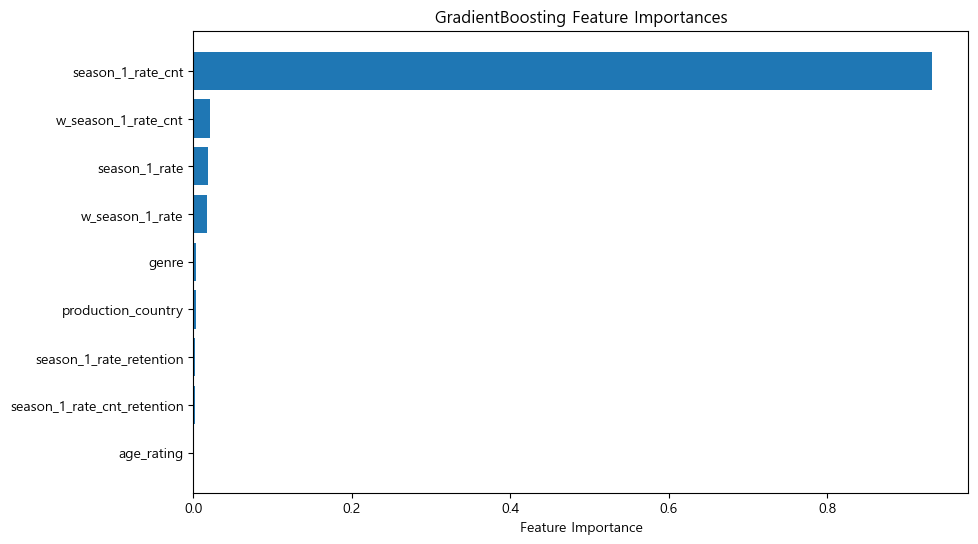

In [199]:
# 인원수에만 로그
X = imdb[['age_rating', 'genre', 'production_country', 'season_1_rate', 'season_1_rate_cnt', 'season_1_rate_retention', 'season_1_rate_cnt_retention', 'w_season_1_rate', 'w_season_1_rate_cnt']]
y = imdb['s2_score_people_log']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=13)

f_p_lx, c_p_lx, r_p_lx = grid_search(X_train, X_test, y_train, y_test, y)

In [200]:
# feature importance
f_p_lx

,Feature,Importance
0,age_rating,0.000093
1,season_1_rate_cnt_retention,0.001973
2,season_1_rate_retention,0.002525
3,production_country,0.002602
4,genre,0.003674
5,w_season_1_rate,0.017403
6,season_1_rate,0.018643
7,w_season_1_rate_cnt,0.021092
8,season_1_rate_cnt,0.931997


In [160]:
# best model 결과 비교
c_p_lx

,korean_title,actual,predicted,diff
Unnamed: 0,,,,
3,스위트 투스: 사슴뿔을 가진 소년,19.332399,22.507970,-3.175571
4,스위트홈,18.431351,18.435085,-0.003734
6,굿 닥터,22.553323,22.553994,-0.000672
7,워킹 데드,27.604997,25.975873,1.629124
8,"비르기트: 왕국, 권력, 영광",17.927687,18.201358,-0.273671
...,...,...,...,...
868,꽃들의 집,15.533553,15.535091,-0.001538
869,우리가 몰랐던 그녀,10.874128,12.595735,-1.721607
881,악플러는 꺼져주세요,16.160505,16.160257,0.000248


In [161]:
# 모델 간 결과 비교
r_p_lx

,Model,MSE,RMSE,MAE,MSLE,RMSLE
0,DecisionTree,3.354329,1.831483,1.397463,0.011059,0.105161
1,LinearRegression,6.977885,2.641569,2.012917,0.019005,0.137858
2,AdaBoost,2.365482,1.538013,1.171752,0.007023,0.083805
3,GradientBoosting,1.737061,1.317976,0.996236,0.005280,0.072663
4,RandomForest,2.071683,1.439334,1.104204,0.006506,0.080660
5,XGBoost,2.375986,1.541423,1.160442,0.006654,0.081570
6,LightGBM,3.283636,1.812080,1.435148,0.009616,0.098059


#### (3)-2 X의 인원 수에 로그

In [162]:
# 인원수에만 로그
X = imdb[['age_rating', 'genre', 'production_country', 'season_1_rate', 'season_1_rate_cnt', 'season_1_rate_retention', 'season_1_rate_cnt_retention', 'w_season_1_rate', 'w_season_1_rate_cnt']]
X[['season_1_rate_cnt', 'w_season_1_rate_cnt']] = X[['season_1_rate_cnt', 'w_season_1_rate_cnt']].apply(lambda x: np.log(x))
y = imdb['s2_score_people_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=13)

f_p_lo, c_p_lo, r_p_lo = grid_search(X_train, X_test, y_train, y_test, y)

C:\Users\mycom\AppData\Local\Temp\ipykernel_9924\644632633.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['season_1_rate_cnt', 'w_season_1_rate_cnt']] = X[['season_1_rate_cnt', 'w_season_1_rate_cnt']].apply(lambda x: np.log(x))


Training DecisionTree...
Best parameters for DecisionTree: {'max_depth': 3}
Training LinearRegression...
Best parameters for LinearRegression: {}
Training AdaBoost...
Best parameters for AdaBoost: {'n_estimators': 100}
Training GradientBoosting...
Best parameters for GradientBoosting: {'learning_rate': 0.1, 'n_estimators': 100}
Training RandomForest...
Best parameters for RandomForest: {'max_depth': 5, 'n_estimators': 50}
Training XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.1, 'n_estimators': 200}
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98
[LightGBM] [Info] Number of data points in the train set: 42, number of used features: 7
[LightGBM] [Info] Start training from score 17.912384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

In [ ]:
# feature importance
f_p_lo

In [163]:
# best model 결과 해석
c_p_lo

,korean_title,actual,predicted,diff
Unnamed: 0,,,,
3,스위트 투스: 사슴뿔을 가진 소년,19.332399,20.906301,-1.573902
4,스위트홈,18.431351,20.194751,-1.763400
6,굿 닥터,22.553323,22.954864,-0.401541
7,워킹 데드,27.604997,27.284577,0.320420
8,"비르기트: 왕국, 권력, 영광",17.927687,17.558169,0.369517
...,...,...,...,...
868,꽃들의 집,15.533553,15.815518,-0.281965
869,우리가 몰랐던 그녀,10.874128,12.327851,-1.453723
881,악플러는 꺼져주세요,16.160505,16.377116,-0.216611


In [164]:
# 모델 간 결과 비교
r_p_lo

,Model,MSE,RMSE,MAE,MSLE,RMSLE
0,DecisionTree,3.559483,1.886659,1.494823,0.010599,0.102950
1,LinearRegression,0.543408,0.737162,0.575333,0.001978,0.044471
2,AdaBoost,2.051279,1.432229,1.095267,0.006229,0.078925
3,GradientBoosting,1.763190,1.327852,0.997135,0.005284,0.072690
4,RandomForest,2.179228,1.476221,1.118907,0.006823,0.082600
5,XGBoost,2.375986,1.541423,1.160442,0.006654,0.081570
6,LightGBM,3.282597,1.811794,1.434311,0.009613,0.098048


### (4) 전체에 로그

#### (4)-1 X에 로그 x

Training DecisionTree...
Best parameters for DecisionTree: {'max_depth': 20}
Training LinearRegression...
Best parameters for LinearRegression: {}
Training AdaBoost...
Best parameters for AdaBoost: {'n_estimators': 200}
Training GradientBoosting...
Best parameters for GradientBoosting: {'learning_rate': 0.1, 'n_estimators': 100}
Training RandomForest...
Best parameters for RandomForest: {'max_depth': 5, 'n_estimators': 50}
Training XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.2, 'n_estimators': 50}
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98
[LightGBM] [Info] Number of data points in the train set: 42, number of used features: 7
[LightGBM] [Info] Start training from score 13.167475
[LightGBM] [Warning] No further splits with positive gain, 

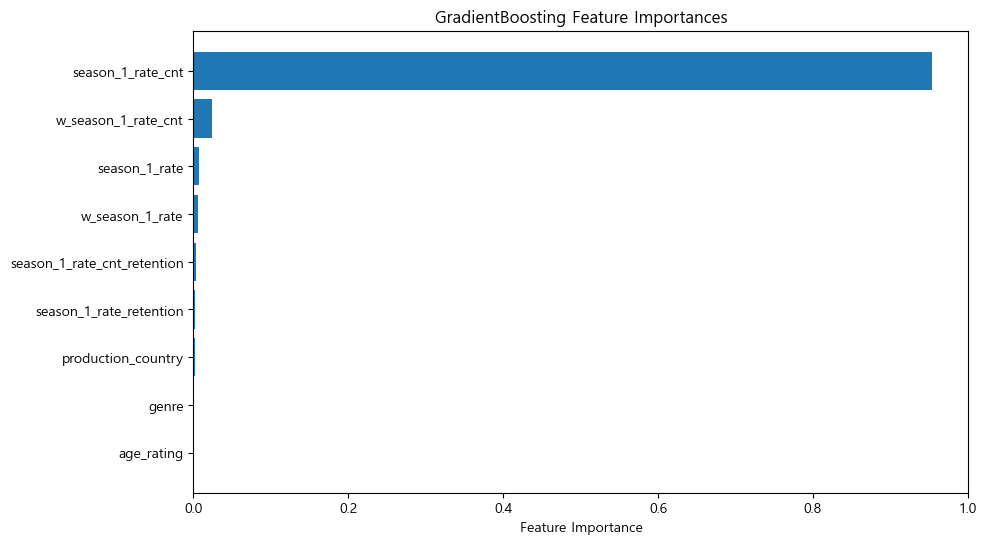

In [201]:
# 전체에 로그
X = imdb[['age_rating', 'genre', 'production_country', 'season_1_rate', 'season_1_rate_cnt', 'season_1_rate_retention', 'season_1_rate_cnt_retention', 'w_season_1_rate', 'w_season_1_rate_cnt']]
y = imdb['s2_score_all_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=13)

f_a_lx, c_a_lx, r_a_lx = grid_search(X_train, X_test, y_train, y_test, y)

In [202]:
# feature importance
f_a_lx

,Feature,Importance
0,age_rating,0.000100
1,genre,0.001024
2,production_country,0.002457
3,season_1_rate_retention,0.002555
4,season_1_rate_cnt_retention,0.003373
5,w_season_1_rate,0.005877
6,season_1_rate,0.007007
7,w_season_1_rate_cnt,0.024464
8,season_1_rate_cnt,0.953143


In [167]:
# best model 결과 해석
c_a_lx

,korean_title,actual,predicted,diff
Unnamed: 0,,,,
3,스위트 투스: 사슴뿔을 가진 소년,14.892829,17.826918,-2.934088
4,스위트홈,14.428980,14.428436,0.000544
6,굿 닥터,17.744850,17.746312,-0.001462
7,워킹 데드,22.593752,20.232842,2.360910
8,"비르기트: 왕국, 권력, 영광",12.498304,13.091279,-0.592976
...,...,...,...,...
868,꽃들의 집,11.270531,11.267828,0.002703
869,우리가 몰랐던 그녀,6.968186,8.467398,-1.499212
881,악플러는 꺼져주세요,11.239756,11.473092,-0.233336


In [168]:
# 모델 간 결과 비교
r_a_lx

,Model,MSE,RMSE,MAE,MSLE,RMSLE
0,DecisionTree,2.850966,1.688480,1.224626,0.017009,0.130420
1,LinearRegression,7.082587,2.661313,2.011696,0.037252,0.193007
2,AdaBoost,1.837898,1.355691,1.049428,0.011120,0.105453
3,GradientBoosting,1.385070,1.176890,0.907921,0.008630,0.092896
4,RandomForest,1.564084,1.250633,0.963649,0.009435,0.097133
5,XGBoost,2.025493,1.423198,1.035562,0.011251,0.106072
6,LightGBM,2.930483,1.711865,1.328042,0.017361,0.131762


#### (4)-2 X 전체에 로그

In [169]:
# 전체에 로그
X = imdb[['age_rating', 'genre', 'production_country', 'season_1_rate', 'season_1_rate_cnt', 'season_1_rate_retention', 'season_1_rate_cnt_retention', 'w_season_1_rate', 'w_season_1_rate_cnt']]
X = X.apply(lambda x: np.log(x))
y = imdb['s2_score_all_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=13)

c_a_lo, r_a_lo = grid_search(X_train, X_test, y_train, y_test, y)

Training DecisionTree...
Best parameters for DecisionTree: {'max_depth': 5}
Training LinearRegression...
Best parameters for LinearRegression: {}
Training AdaBoost...
Best parameters for AdaBoost: {'n_estimators': 200}
Training GradientBoosting...
Best parameters for GradientBoosting: {'learning_rate': 0.1, 'n_estimators': 100}
Training RandomForest...
Best parameters for RandomForest: {'max_depth': None, 'n_estimators': 100}
Training XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.2, 'n_estimators': 50}
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98
[LightGBM] [Info] Number of data points in the train set: 42, number of used features: 7
[LightGBM] [Info] Start training from score 13.167475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [170]:
# best model 결과 해석
c_a_lo

,korean_title,actual,predicted,diff
Unnamed: 0,,,,
3,스위트 투스: 사슴뿔을 가진 소년,14.892829,16.202464,-1.309635
4,스위트홈,14.428980,15.742451,-1.313472
6,굿 닥터,17.744850,18.265386,-0.520536
7,워킹 데드,22.593752,22.378761,0.214991
8,"비르기트: 왕국, 권력, 영광",12.498304,12.150571,0.347733
...,...,...,...,...
868,꽃들의 집,11.270531,10.905361,0.365170
869,우리가 몰랐던 그녀,6.968186,8.162062,-1.193876
881,악플러는 꺼져주세요,11.239756,11.888872,-0.649116


In [171]:
# 모델 간 결과 비교
r_a_lo

,Model,MSE,RMSE,MAE,MSLE,RMSLE
0,DecisionTree,2.806467,1.675251,1.228910,0.015314,0.123749
1,LinearRegression,0.378613,0.615315,0.483153,0.003297,0.057423
2,AdaBoost,1.850278,1.360249,1.025866,0.010424,0.102100
3,GradientBoosting,1.413682,1.188984,0.907459,0.008749,0.093537
4,RandomForest,1.689674,1.299874,0.998051,0.009996,0.099980
5,XGBoost,2.025493,1.423198,1.035562,0.011251,0.106072
6,LightGBM,2.930319,1.711817,1.327503,0.017361,0.131760


### (5) 전체에 log1p

#### (5)-1 X에 로그 x

Training DecisionTree...
Best parameters for DecisionTree: {'max_depth': 10}
Training LinearRegression...
Best parameters for LinearRegression: {}
Training AdaBoost...
Best parameters for AdaBoost: {'n_estimators': 200}
Training GradientBoosting...
Best parameters for GradientBoosting: {'learning_rate': 0.2, 'n_estimators': 200}
Training RandomForest...
Best parameters for RandomForest: {'max_depth': 20, 'n_estimators': 50}
Training XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.2, 'n_estimators': 100}
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98
[LightGBM] [Info] Number of data points in the train set: 42, number of used features: 7
[LightGBM] [Info] Start training from score 14.319070
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

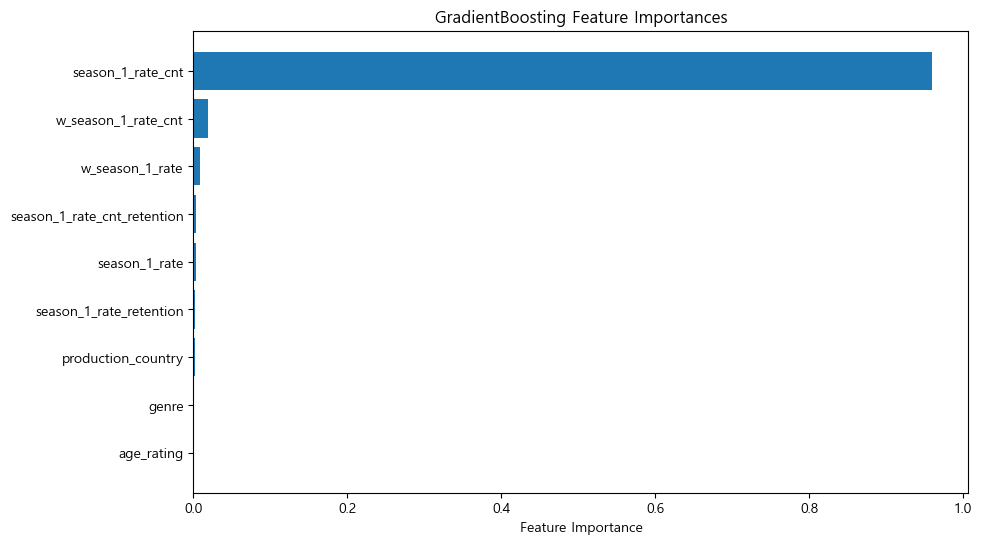

In [203]:
# 전체에 log1p
X = imdb[['age_rating', 'genre', 'production_country', 'season_1_rate', 'season_1_rate_cnt', 'season_1_rate_retention', 'season_1_rate_cnt_retention', 'w_season_1_rate', 'w_season_1_rate_cnt']]
y = imdb['s2_score_all_log1p']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=13)

f_a_lpx, c_a_lpx, r_a_lpx = grid_search(X_train, X_test, y_train, y_test, y)

In [204]:
# feature importance
f_a_lpx

,Feature,Importance
0,age_rating,0.000063
1,genre,0.000854
2,production_country,0.001966
3,season_1_rate_retention,0.002187
4,season_1_rate,0.003600
5,season_1_rate_cnt_retention,0.003863
6,w_season_1_rate,0.008771
7,w_season_1_rate_cnt,0.019420
8,season_1_rate_cnt,0.959277


In [173]:
# best model 결과 해석
c_a_lpx

,korean_title,actual,predicted,diff
Unnamed: 0,,,,
3,스위트 투스: 사슴뿔을 가진 소년,15.822102,18.661699,-2.839598
4,스위트홈,15.499193,15.524807,-0.025613
6,굿 닥터,18.635433,18.678175,-0.042743
7,워킹 데드,23.419751,21.877012,1.542738
8,"비르기트: 왕국, 권력, 영광",14.108318,14.599737,-0.491419
...,...,...,...,...
868,꽃들의 집,12.500831,12.447889,0.052942
869,우리가 몰랐던 그녀,8.372207,9.890151,-1.517945
881,악플러는 꺼져주세요,12.324610,12.915891,-0.591282


In [174]:
# 모델 간 결과 비교
r_a_lpx

,Model,MSE,RMSE,MAE,MSLE,RMSLE
0,DecisionTree,2.026143,1.423427,1.122888,0.010709,0.103482
1,LinearRegression,6.793907,2.606513,1.971786,0.029140,0.170706
2,AdaBoost,1.804527,1.343327,1.026435,0.008661,0.093063
3,GradientBoosting,1.426218,1.194244,0.905755,0.007167,0.084659
4,RandomForest,1.372993,1.171748,0.898447,0.006508,0.080674
5,XGBoost,1.828979,1.352397,0.967154,0.008049,0.089715
6,LightGBM,2.752849,1.659171,1.284263,0.012679,0.112603


#### (5)-2 X에 로그를 취함

In [175]:
# 전체에 log1p
X = imdb[['age_rating', 'genre', 'production_country', 'season_1_rate', 'season_1_rate_cnt', 'season_1_rate_retention', 'season_1_rate_cnt_retention', 'w_season_1_rate', 'w_season_1_rate_cnt']]
X = X.apply(lambda x: np.log1p(x))
y = imdb['s2_score_all_log1p']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=13)

c_a_lpo, r_a_lpo = grid_search(X_train, X_test, y_train, y_test, y)

Training DecisionTree...
Best parameters for DecisionTree: {'max_depth': 5}
Training LinearRegression...
Best parameters for LinearRegression: {}
Training AdaBoost...
Best parameters for AdaBoost: {'n_estimators': 100}
Training GradientBoosting...
Best parameters for GradientBoosting: {'learning_rate': 0.1, 'n_estimators': 200}
Training RandomForest...
Best parameters for RandomForest: {'max_depth': 10, 'n_estimators': 50}
Training XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.2, 'n_estimators': 100}
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98
[LightGBM] [Info] Number of data points in the train set: 42, number of used features: 7
[LightGBM] [Info] Start training from score 14.319070
[LightGBM] [Warning] No further splits with positive gain,

In [176]:
# best model의 결과 해석
c_a_lpo

,korean_title,actual,predicted,diff
Unnamed: 0,,,,
3,스위트 투스: 사슴뿔을 가진 소년,15.822102,17.135452,-1.313350
4,스위트홈,15.499193,16.723553,-1.224359
6,굿 닥터,18.635433,19.129888,-0.494456
7,워킹 데드,23.419751,23.212042,0.207709
8,"비르기트: 왕국, 권력, 영광",14.108318,13.768600,0.339719
...,...,...,...,...
868,꽃들의 집,12.500831,12.114312,0.386519
869,우리가 몰랐던 그녀,8.372207,9.551339,-1.179133
881,악플러는 꺼져주세요,12.324610,12.932091,-0.607481


In [177]:
# 모델 간 성능 비교
r_a_lpo

,Model,MSE,RMSE,MAE,MSLE,RMSLE
0,DecisionTree,1.934008,1.390686,1.085152,0.009933,0.099663
1,LinearRegression,0.337101,0.580604,0.458417,0.002123,0.046075
2,AdaBoost,1.681562,1.296751,0.989801,0.008302,0.091113
3,GradientBoosting,1.358063,1.165360,0.879049,0.007004,0.083692
4,RandomForest,1.471866,1.213205,0.923407,0.007339,0.085667
5,XGBoost,1.828979,1.352397,0.967154,0.008049,0.089715
6,LightGBM,2.753422,1.659344,1.283954,0.012688,0.112641
